# RNN 이해 및 실습

## 1. 시계열 데이터

- 예제 시계열 만들기

In [1]:
import numpy as np
import matplotlib.pyplot as plt

xarr = np.array([100,200,300,400])
yarr = np.array([1,2,3,4])
cond = ([True,False,True,False])
np.where(cond,xarr,yarr) #cond True->xarr, False ->yarr

np.random.seed(2020)

time = np.arange(30 * 12 + 1)
month_time = (time % 30) / 30
time_series = 20 * np.where(month_time < 0.5,
                          np.cos(2 * np.pi * month_time),
                          np.cos(2 * np.pi * month_time) + np.random.random(361))


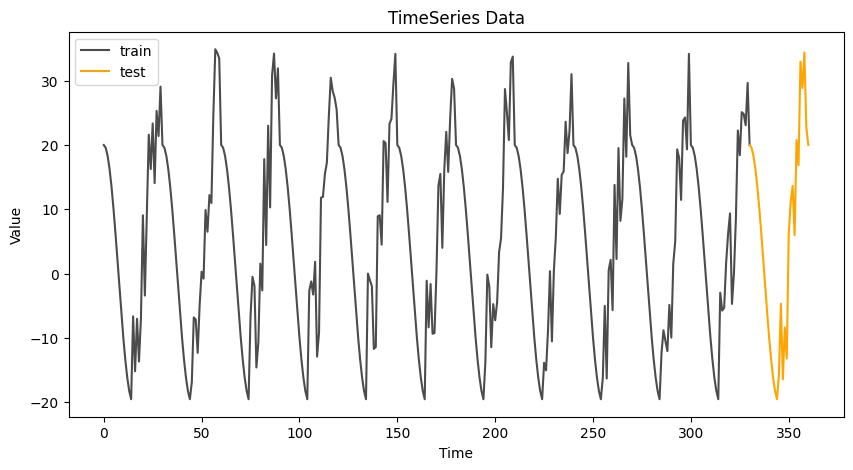

In [2]:
plt.figure(figsize = (10, 5))
plt.title('TimeSeries Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(np.arange(0, 30 * 11 + 1), time_series[:30 * 11 + 1], color = 'black', alpha = 0.7, label = 'train') # 학습용 데이터
plt.plot(np.arange(30 * 11, 30 * 12 + 1), time_series[30 * 11:], color = 'orange', label = 'test') # 테스트용 데이터
plt.legend()

## 2. 시계열 데이터 전처리 : Sequence를 만들기

In [3]:
def make_sequence(time_series, n):  #시계열에서 1부터 n번째까지 선택해서 x로 지정, n+1번째값은 y, 이런 식으로 시계열 값을 계속 윈도우 n크기로 슬라이딩
    x_train, y_train = list(), list()

    for i in range(len(time_series)):      #0
        x = time_series[i:(i + n)]            #0:0+n
        if (i + n) < len(time_series):
            x_train.append(x)
            y_train.append(time_series[i + n])
        else:
            break

    return np.array(x_train), np.array(y_train)

# 위는 하나하나 오른쪽으로 밀려가며 1차원 어레이를 하나하나 아래로 적은것이 아래 np.array(x_train)이것이 2차원으로 된다.



In [6]:
n = 15
x_train, y_train = make_sequence(time_series, n)
x_train = x_train.reshape(-1, n, 1)
y_train = y_train.reshape(-1, 1)
print(x_train.shape)
print(y_train.shape)

(346, 15, 1)
(346, 1)


In [7]:
x_train

array([[[ 20.        ],
        [ 19.56295201],
        [ 18.27090915],
        ...,
        [-16.18033989],
        [-18.27090915],
        [-19.56295201]],

       [[ 19.56295201],
        [ 18.27090915],
        [ 16.18033989],
        ...,
        [-18.27090915],
        [-19.56295201],
        [ -6.66393899]],

       [[ 18.27090915],
        [ 16.18033989],
        [ 13.38261213],
        ...,
        [-19.56295201],
        [ -6.66393899],
        [-15.22093924]],

       ...,

       [[-18.27090915],
        [-19.56295201],
        [-15.5886655 ],
        ...,
        [ 16.83501896],
        [ 32.97641254],
        [ 28.86423556]],

       [[-19.56295201],
        [-15.5886655 ],
        [ -4.70138381],
        ...,
        [ 32.97641254],
        [ 28.86423556],
        [ 34.38901865]],

       [[-15.5886655 ],
        [ -4.70138381],
        [-16.4676662 ],
        ...,
        [ 28.86423556],
        [ 34.38901865],
        [ 22.67349615]]])

In [8]:
from sklearn.model_selection import train_test_split

partial_x_train = x_train[:30 * 11]
partial_y_train = y_train[:30 * 11]
x_test = x_train[30 * 11:]
y_test = y_train[30 * 11:]

print('train:', partial_x_train.shape, partial_y_train.shape)
print('test:',x_test.shape, y_test.shape)

train: (330, 15, 1) (330, 1)
test: (16, 15, 1) (16, 1)


## 3. sequence 함수 확인하기

In [9]:
test_arr = np.arange(100)
a, b = make_sequence(test_arr, 15)

for i in range(1, 4):
    print(a[i],'|', b[i])


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] | 16
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] | 17
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] | 18


## 4. SimpleRNN 구축

- tanh: Hyperbolic tangent 함수
- -1~1사이의 값, 출력범위가 sigmoid보다 크고, 경사가 큰 구간이 많아 sigmoid보다 빠르게 수렴하여 학습하는 특성
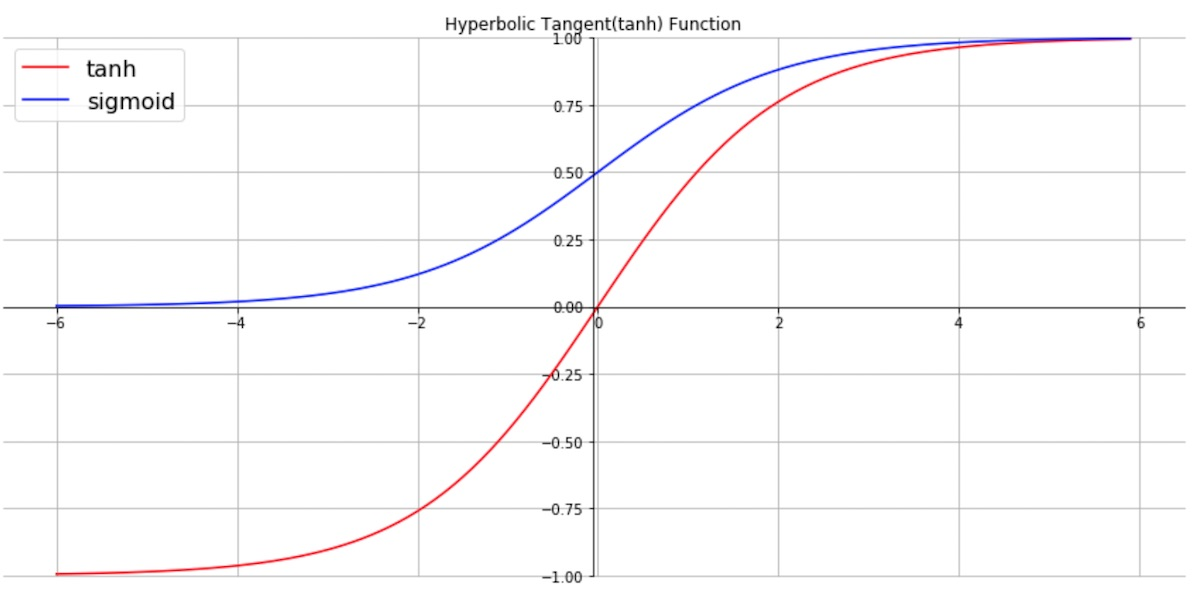

In [10]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential

model = Sequential()
# SimpleRNN 층을 첫 번째 은닉층인 경우, input_shape를 명시
model.add(SimpleRNN(units = 32, activation = 'tanh', input_shape = (n, 1))) #units: output의 dimension, relu대신 tanh 사용
#model.add(LSTM(units = 32, activation = 'tanh', input_shape = (n, 1)))
#model.add(GRU(units = 32, activation = 'tanh', input_shape = (n, 1)))

#rnn은 이전 단계의 가중치를 사용하며, relu 를 사용하면, 역전파 시 이전 단계의 그라디언트와 같이 사용되면 출력이 발산
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse')  #mean squared error
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model.fit(x_train, y_train, epochs = 30, batch_size = 1)

Epoch 1/30
346/346 [==============================] - 4s 5ms/step - loss: 150.9362
Epoch 2/30
346/346 [==============================] - 2s 6ms/step - loss: 84.1689
Epoch 3/30
346/346 [==============================] - 2s 7ms/step - loss: 64.9884
Epoch 4/30
346/346 [==============================] - 2s 4ms/step - loss: 56.1146
Epoch 5/30
346/346 [==============================] - 1s 4ms/step - loss: 52.0299
Epoch 6/30
346/346 [==============================] - 3s 9ms/step - loss: 46.6278
Epoch 7/30
346/346 [==============================] - 3s 10ms/step - loss: 41.4863
Epoch 8/30
346/346 [==============================] - 2s 5ms/step - loss: 37.4607
Epoch 9/30
346/346 [==============================] - 1s 4ms/step - loss: 34.5959
Epoch 10/30
346/346 [==============================] - 2s 4ms/step - loss: 32.0070
Epoch 11/30
346/346 [==============================] - 1s 4ms/step - loss: 30.3344
Epoch 12/30
346/346 [==============================] - 1s 4ms/step - loss: 28.9749
Epoch 13/30

## 5. 예측 VS Actual


1/1 [==============================] - 0s 349ms/step


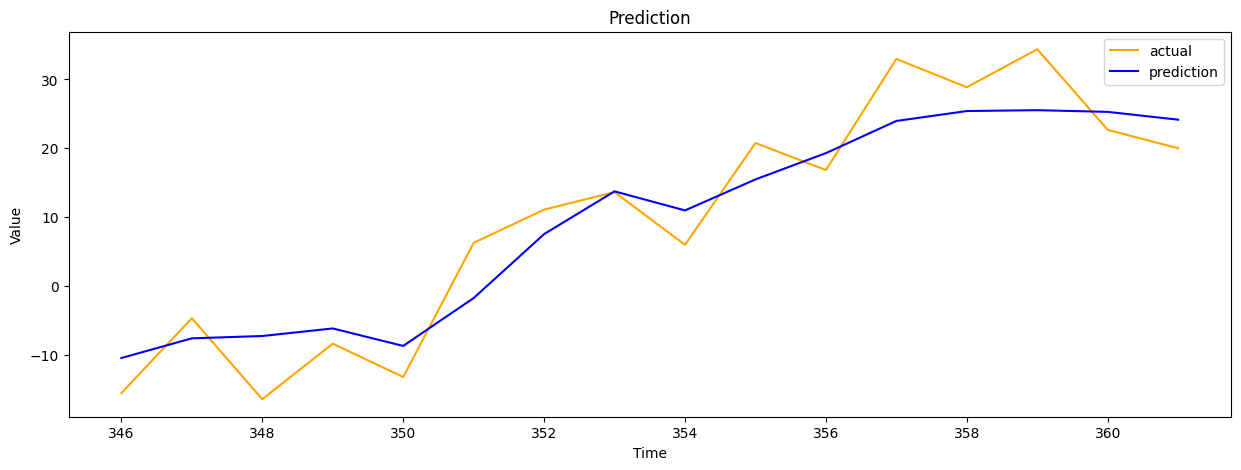

In [12]:
pred = model.predict(x_test)
pred_range = np.arange(len(y_train), len(y_train) + len(pred))

plt.figure(figsize=(15,5))
plt.title('Prediction')
plt.xlabel('Time'); plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='actual')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()

## 6. 두번째 RNN 실습




- RNN 입력 x 데이터의 shape: (n_sample, time step, x vector의 크기)
 - n_sample: sample의 수
 - time step: t-n 에서 n이 몇인가를 묻는 것
 - x vector의 크기: 현재는 1개, 추후 여러 값이 입력, 여러값이 출력될 수 있음. x변수의 값 1개의 크기임
 - xvector의 크기 = yvector의 크기와 동일

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

s = np.sin(2 * np.pi * 0.125 * np.linspace(0, 20, 50))
timestep =3 # t-3, t-2, t-1 데이터를 이용하여 t 시점의 값을 예측
xs, ys = [], []

for i in range(timestep, len(s)):
    xs.append(np.array([s[i-j] for j in range(timestep, 0, -1)]))
    ys.append(s[i])
xs, ys = np.array(xs).reshape(len(xs), 3, 1), np.array(ys).reshape(len(ys), 1)
print(xs.shape)

(47, 3, 1)


2/2 [==============================] - 0s 5ms/step


<ipython-input-14-f9a3a7d27bf0>:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(model0.predict(xs), 'bo-', marker='o', label='model0')


2/2 [==============================] - 0s 6ms/step


<ipython-input-14-f9a3a7d27bf0>:25: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(model1.predict(xs), 'go-', marker='o', label='model1')


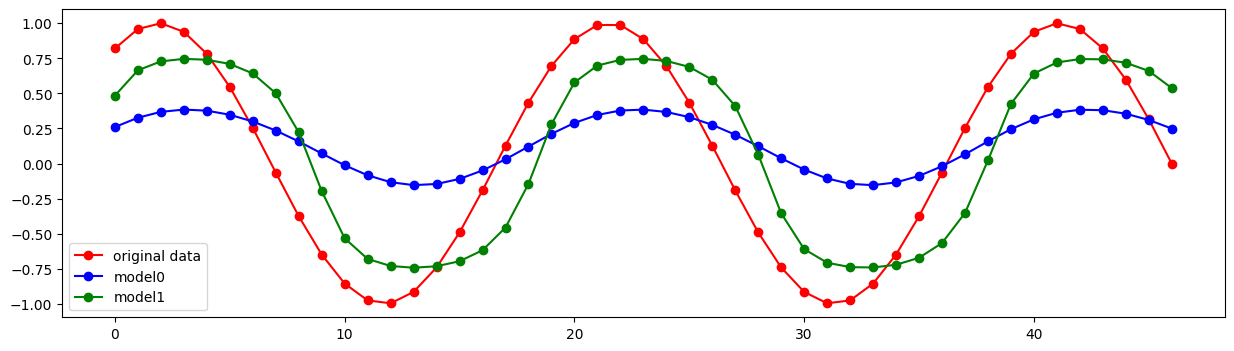

In [14]:
## rnn 적용.
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

## simple RNN model
np.random.seed(0)# seed 고정
model0 = Sequential()
model0.add( SimpleRNN(units=1, input_shape=(3, 1)))
model0.compile(loss='mse', optimizer='sgd')
history0 = model0.fit(xs, ys, epochs=150, verbose=0)


model1 = Sequential()
model1.add( SimpleRNN(units=1, input_shape=(3, 1)) )
model1.add( Dense(10, activation='linear') )
model1.add( Dense(1, activation='linear') )
model1.compile(loss='mse', optimizer='sgd')
history1 = model1.fit(xs, ys, epochs=150, verbose=0)


## plot
fig = plt.figure(figsize=(15, 4))
plt.plot(s[3:], 'ro-', label='original data') # 원래 plot, 앞의 3칸의 경우,
plt.plot(model0.predict(xs), 'bo-', marker='o', label='model0')
plt.plot(model1.predict(xs), 'go-', marker='o', label='model1')
plt.legend()

plt.savefig('simple_rnn.svg')
plt.show()

## 7. RNN 활용 기온 예측 예제: Sequence 만들기
- 10분 간격 기록된 (기온, 기압, 습도, 풍향 등과 같은) 14개의 관측값
- 원본 데이터는 2003년부터, 예제에서 2009~2016년 사이의 데이터만 사용
- 최근 데이터(몇 일치 데이터 포인트)를 입력, 1일 후 기온 예측

In [15]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip /content/jena_climate_2009_2016.csv.zip

--2024-05-29 04:55:58--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.233.104, 54.231.234.216, 52.217.203.0, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.233.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  20.0MB/s    in 0.6s    

2024-05-29 04:55:59 (20.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  /content/jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [16]:
import pandas as pd
test = pd.read_csv("jena_climate_2009_2016.csv")


In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420451 entries, 0 to 420450
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420451 non-null  float64
 1   T (degC)         420451 non-null  float64
 2   Tpot (K)         420451 non-null  float64
 3   Tdew (degC)      420451 non-null  float64
 4   rh (%)           420451 non-null  float64
 5   VPmax (mbar)     420451 non-null  float64
 6   VPact (mbar)     420451 non-null  float64
 7   VPdef (mbar)     420451 non-null  float64
 8   sh (g/kg)        420451 non-null  float64
 9   H2OC (mmol/mol)  420451 non-null  float64
 10  rho (g/m**3)     420451 non-null  float64
 11  wv (m/s)         420451 non-null  float64
 12  max. wv (m/s)    420451 non-null  float64
 13  wd (deg)         420451 non-null  float64
dtypes: float64(14)
memory usage: 44.9 MB


In [17]:
test.drop("Date Time", axis=1, inplace=True)

In [18]:
float_data = test.values
float_data[:,1]

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

연습 시작 \
n=10, 행은 1:2000행 선택, 80%:20%, SimpleRNN \
2:07 \

In [25]:
import pandas as pd
test = pd.read_csv("jena_climate_2009_2016.csv")

In [29]:
test.drop("Date Time", axis=1, inplace=True)

In [31]:
test

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420446,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420447,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420448,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420449,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


연습 종료

- 시간별 기온(섭씨) 그래프

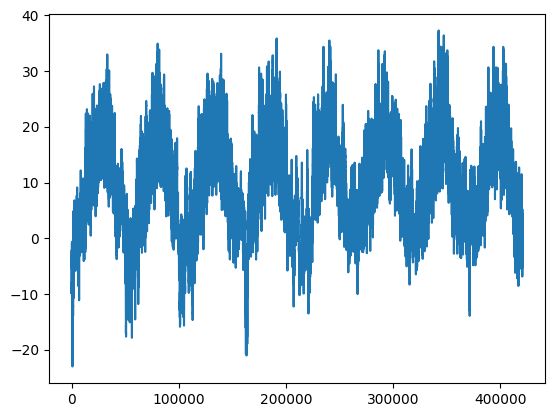

In [32]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # 온도(섭씨)
plt.plot(range(len(temp)), temp)
plt.show()

- 기온의 주기성
- 첫 10일간의 기온 데이터, 10분 간격으로 하루에 144개 관측치
- 일별 주기성, 일일 기온 변화가 크고, 시계열 데이터로 예측

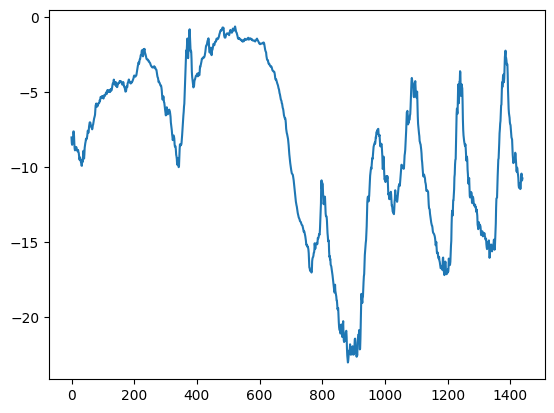

In [33]:
plt.plot(range(1440), temp[:1440])
plt.show()

### 데이터 준비 및 전처리
- lookback 타임스텝(하나의 타임스텝은 10분) 지정, 이 만큼 이전으로 가서 샘플링, 24시간 delay후 기온 예측

 - lookback = 1440 : 10일 전 데이터로 돌아갑니다.
 - steps = 6 : 한 시간마다 데이터 포인트 하나를 샘플링합니다.
 - delay = 144 : 24시간이 지난 데이터가 타깃이 됩니다.

- 데이터 전처리: 값의 스케일링
- float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출
 - 모든 샘플을 각기 메모리에 올리는 것은 비효율적이어서, 필요 시 원본 데이터에서 배치를 생성
 - 각 값은 standard scaling
 - 전체 데이터 중 20만개 observation을 train으로 사용, 표준화 시 해당 범위 내 data로 평균 및 편차 계산

데이터 전처리: 값의 스케일링 하냐 마냐 이것을 고민해봐야합니다 잘 될수도 있고 안될 수도 있고 편차와 평균이 안바뀌라는 법이 없기에

In [34]:
float_data

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
float_data = scaler.fit_transform(float_data)


- Sequence 제너레이터:(samples, targets) 튜플을 반복적으로 반환. samples는 입력 데이터로 사용할 배치이고 targets은 이에 대응되는 타깃 온도의 배열
 - data : 정규화한 부동 소수 데이터로 이루어진 원본 배열
 - lookback : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
 - delay : 타깃으로 사용할 미래의 타임스텝
 - min_index와 max_index : 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용
 - shuffle : 샘플을 섞을지 시간 순서대로 추출할지 결정, 시간순서대로 사용
 - batch_size : 배치의 샘플 수
 - step : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정

In [36]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

- 데이터 파티셔닝
 - training: 20만개
 - validating: 그 다음 10만개
 - testing : 나머지

In [37]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=False,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

- 모형 성능 평가를 위해, 24시간 뒤 기온이 현재와 동일한 경우의 예측 성능을 MAE로 측정
 - MAE 계산:  np.mean(np.abs(preds - targets))

 - MSE(mean squared error)
 - RMSE(root MSE)
 - MAE
 - MAPE


In [38]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.3044855621388976


 - MAE: 0.29 (평균0, 편차 1인 상황)
 - MAE X 표준편차: 2.57, 기온 예측 시 오차 정도

In [39]:
0.30 * scaler.scale_[1]

2.5271025170748156

## 8. RNN 응용
- sequence 데이터로 반영: 시간 순서를 적용
- LSTM 과 GRU의 비교(RNN의 한 종류, LSTM의 단순화 버전)

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model1 = Sequential()
model1.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model1.add(layers.Dense(1))

model1.compile(optimizer=RMSprop(), loss='mae')
history1 = model1.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5


<ipython-input-40-0d5a5172793c>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model1.fit_generator(train_gen,


50/50 [==============================] - 74s 1s/step - loss: 0.3463 - val_loss: 0.5401
Epoch 2/5
50/50 [==============================] - 62s 1s/step - loss: 0.3506 - val_loss: 0.5089
Epoch 3/5
50/50 [==============================] - 54s 1s/step - loss: 0.4099 - val_loss: 0.4718
Epoch 4/5
50/50 [==============================] - 88s 2s/step - loss: 0.2987 - val_loss: 0.4524
Epoch 5/5
50/50 [==============================] - ETA: 0s - loss: 0.3012

KeyboardInterrupt: 

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='GRU-Training loss')
plt.plot(epochs, val_loss, 'b', label='GRU-Validation loss')

plt.plot(epochs, loss1, 'ro', label='LSTM-Training loss')
plt.plot(epochs, val_loss1, 'r', label='LSTM-Validation loss')

plt.title('Training and validation loss')
plt.legend()

plt.show()